<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2018, семинар 1</span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<span style="color:black; font-size: 14pt">Plan</span>
* Метрические алгоритмы (30 мин)
    - kNN
    - <span style="color:gold; font-size: 12pt"> Метрики </span> (опционально)
    - Проклятие размерности
* Визуализация данных в Python (20 мин)
    - <span style="color:gold; font-size: 12pt"> Визуализация в Python </span> (опционально)
    - Границы классов для kNN
    - kNN для гауссовских распределений 
* Cross validation (30 мин)
    - Переобучение
    - Примеры разбиения выборки в Python
    - Разбиение выборки на train, validate и test

<span style="color:black; font-size: 16pt">Key words</span>
   * метрические алгоритмы, kNN
   * проклятие размерности
   * кросс-валидация, переобучение, различные варианты кросс-валидации
   * разбиение на трейн, валидейт и тест 

### Imports

In [103]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle, normalvariate, SystemRandom
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pylab, gridspec, pyplot as plt
from matplotlib.colors import ListedColormap

from IPython.display import Image

from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neighbors.base import _get_weights
%matplotlib inline

<h1 align="center"> Метрические алгоритмы </h1>

## Data: Kaggle Digit Recognizer 

Link: http://www.kaggle.com/c/digit-recognizer 
Description: Classify handwritten digits using the famous MNIST data Advanced Reading: http://yann.lecun.com/exdb/mnist/index.html

In [2]:
path = 'C:/Users/rusrom.EUROPE/OneDrive/Teaching/MachineLearning/data' # путь к папке с данными
mnist = pd.read_csv(path+'/digit_recognizer/train.csv')

In [159]:
indices = np.random.permutation(mnist.shape[0])

mnist_train = mnist.iloc[indices[:15000]]
Y_train = mnist_train['label'].values
X_train = mnist_train[mnist_train.columns[1:]].values

mnist_test = mnist.iloc[indices[15000:20000]]
Y_test = mnist_test['label'].values
X_test = mnist_test[mnist_test.columns[1:]].values

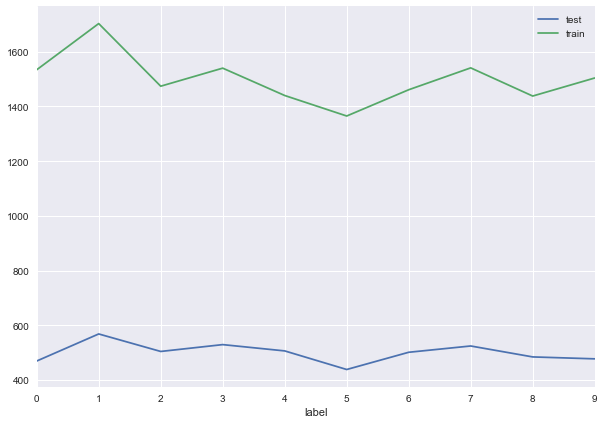

In [163]:
pd.DataFrame({
    'train' : mnist_train.groupby('label')['label'].count(),
    'test' : mnist_test.groupby('label')['label'].count(),
}).plot(figsize = (10,7))

Нарисуем цифры из датасета

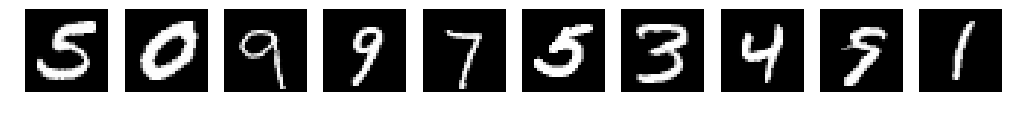

In [162]:
def plot_image(image_id, dataset=X_train, im_size=28):
    pylab.imshow(255-dataset[image_id,:].reshape(im_size, im_size))
    
def plot_grid(image_ids, nrows, ncols, dataset=X_train, im_size=28):
    fig = plt.gcf()
    fig.set_size_inches(17.5,15.5)
    for pylab_index, example_id in enumerate(image_ids):
        pylab.subplot(nrows, ncols, pylab_index + 1)
        plot_image(example_id, dataset, im_size)
        pylab.axis('off')
plot_grid(range(10), nrows=1, ncols=10)

# K near neighbours (kNN )

Одна из самых простых идей -- взять класс наиболее близких (похожих объектов) к объекту $u$.

<img src='img/knn-concept.png'>

# K Nearest Neighbors

Выразим эту идею в виде формулы.

## $$a(u, X^l) = \arg \max_{y \in Y} \sum_{i=1}^{k} [y^{(i)} = y]$$
### $(x^{(i)}, y^{(i)})$ - $i$-й сосед объекта $u$ относительно некоторой метрики

In [171]:
def get_neighbors(example_img, X_minus_example, Y_minus_example, estimator):
    distances, indices = estimator.kneighbors(example_img.reshape(1, -1), n_neighbors=10)
    distances, indices = distances[0], indices[0]
    
    df = pd.DataFrame()
    df['distances'], df['indices']  = distances, indices
    df['labels'] = Y_minus_example[indices]
    
    return df

Выберем случайный не очень хороший объект, и посмотрим на 5 ближайших соседей

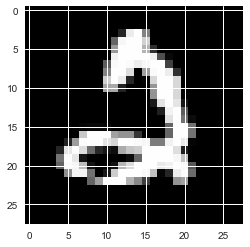

In [185]:
example_id = 58
plot_image(example_id)

In [186]:
estimator = KNeighborsClassifier().fit(X_train, Y_train)
get_neighbors(X_train[example_id], X_train, Y_train, estimator)

,distances,indices,labels
0,0.000000,58,2
1,1475.146094,10318,2
2,1736.452130,2671,2
3,1780.426073,7424,2
4,1887.125062,1742,0
5,1910.400743,11762,2
6,1918.219487,11443,2
7,1930.933194,8170,3
8,1947.103747,411,2
9,1950.235370,14064,0


Как предсказать вероятности классов при условии объекта?

In [188]:
prediction = estimator.predict_proba(X_train[example_id].reshape(1,-1))
print (', '.join('y=%s: %.2f' % e for e in enumerate(prediction[0]) if e[1] != 0))

y=0: 0.20, y=2: 0.80


## Отступ, эталонные объекты

Рассмотрим классификатор: 
## $$a: X \rightarrow Y $$

## $$ a(x) = {\mathrm{argmax}} (\Gamma_y(x)), y \in Y, x \in X $$

** Как найти выбросы в обучающей выборке? **

Отступ: 
## $$ M(x_i) = \Gamma_{y_i}(x_i) - \max_{y \in Y \setminus y_i} \Gamma_{y}(x_i) $$
<img src="img/Margin.png">

In [189]:
# Caution: takes 2 minutes
neighbors_for_test = estimator.kneighbors(X_test, 10, return_distance=False)

In [190]:
counts = [np.bincount(x, minlength=10) for x in Y_train[neighbors_for_test]]

In [191]:
ideals = []
noise = []
for i, bincount in enumerate(counts):
    if bincount[Y_test[i]] == 0:
        noise.append(i)
    elif bincount[Y_test[i]] == 10:
        ideals.append(i)
        
print( len(ideals), len(noise))

3696 29


** Noise: **

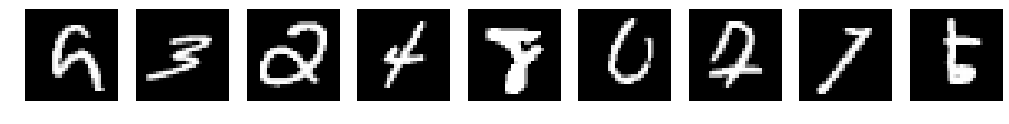

In [192]:
plot_grid(noise[9:18], 1, 9, dataset=X_test, im_size=28)

### Etalones:

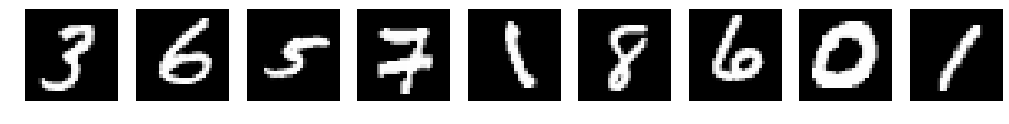

In [193]:
plot_grid(ideals[:9], 1, 9, dataset=X_test, im_size=28)

** Вопрос:**
   * Как по линии маржинов (см. картинку выше) определить, какая из двух метрик лучше?

# Метрики

** Вопросы **
* Почему Евклидова метрика не всегда подходит?
  - Простым примером является классификация пола человека по зарплате и росту --- зарплата измеряется в тысячах рублей а рост в метрах, но при использовании эвклидовой метрики разница в 1 рубль в зарплате будет эквивалентна разнице в 1 метр в росте человека. Тогда расстояние между людьми будет определяться исключительно зарплатой, а пост будет играть роль только при условии равны зарплат.

* Какие вы знаете другие метрики (расстояния)?
 - Минковского
     - Хемминга
     - Чебышева
 - Косинусная
 - Джаккарда
 - Махалонобиса
 - Левенштейна

In [55]:
from scipy.spatial.distance import cosine, euclidean, minkowski
x_exampe = X_test[10]

## Minkowski Distance

### $$p(x, x_i) = \left(\sum_{j} w_j \cdot |f_j(x) - f_j(x_i)| ^p \right) ^ {\frac{1}{p}}$$

### $w_i$ - веса признаков (нормировка),$~f_j$ - возможно, нелинейное преобразование

<img src='img/1.png'>
<img src='img/3.png'>
<img src='img/2.png'>

Дисперсии весов уменьшаются с ростом p, даже при p=2 веса распределены нормально.

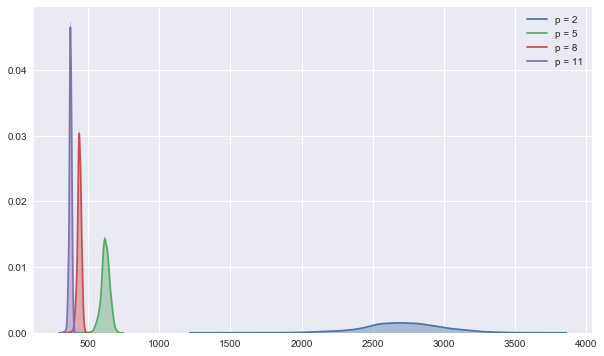

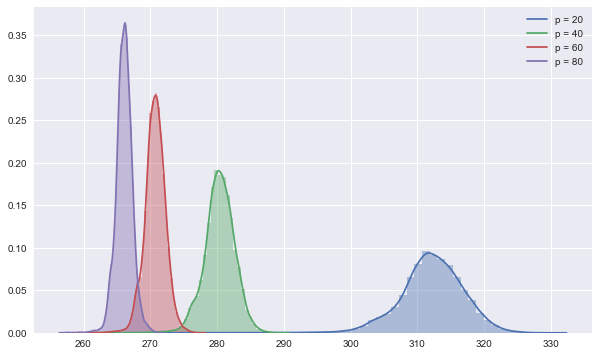

In [60]:
plt.figure(figsize=(10, 6))
for p in range(2, 12, 3):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

plt.figure(figsize=(10, 6))
for p in range(20, 100, 20):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

Можно сделать вывод, что дисперсия растояния между объектами уменьшается с ростом степени метрики --- все растояния примерно равны.

## Cosine Distance

## $$\text{similarity} = \cos(\theta) = {A \cdot B \over \|A\| \|B\|} = \frac{ \sum\limits_{i=1}^{n}{A_i \times B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{(A_i)^2}} \times \sqrt{\sum\limits_{i=1}^{n}{(B_i)^2}} }$$

<img src = 'https://comsysto.files.wordpress.com/2013/02/euclidean_pearson_similarity.png'>

Расстояния, посчитаные с помошью косинусной меры имеют большую дисперсию, веса соседей отличаются сильнее.

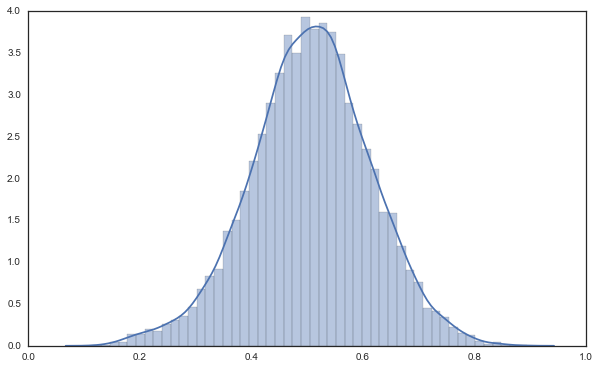

In [39]:
plt.figure(figsize=(10, 6))
cosin_dists = [cosine(x, x_exampe) for x in X_train]
sns.distplot(cosin_dists)

## Jaccard Index (метрика Джаккарда)

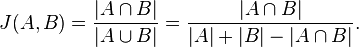

In [11]:
Image(url='https://upload.wikimedia.org/math/0/a/0/0a0633ce67c9130d890078a8d67f0474.png', embed=True)

In [12]:
Image(url='https://upload.wikimedia.org/math/a/2/8/a28e1c667f0354898727933aa746179e.png', embed=True)

# Выбираем метрику для MNIST

In [200]:
def calculate_margin(estimator, class_id, example, Y_train=Y_train, debug=False):
    """
    We assume that we have uniform weights. We also assume
    that we fit our estimator on the whole set. It means
    that we already have our example inside estimator. That is
    why, the first nearest neighbor would be example object.
    
    @param estimator: KNeighborsMixin sublcassed object
        should be already fitted.
    @param class_id: example object has class class_id
    @param example: numpy.array feature represenation of
        example (1x784 matrix based on 28x28 reshaping)
    @param Y_train: we should know object class by its index id
    @params debug: do we need to print debug information?
    """
    counts = Counter(Y_train[estimator.kneighbors([example])[1][0][1:]])
    if debug:
        # in production environment we should use logging module!
        print(counts)
    margin = counts[class_id]
    del counts[class_id]
    if counts:
        margin -= max(counts.values())
    margin *= 1.0 / (estimator.n_neighbors - 1)
    return margin

In [212]:
from tqdm import tqdm
def collect_margins(n_neighbors, X_train=X_train, Y_train=Y_train, debug_example_id = None, **kwargs):
    margins = []
    estimator = NearestNeighbors(n_neighbors=n_neighbors + 1, **kwargs)
    estimator.fit(X_train)
    for example_id, (class_id, example) in tqdm(enumerate(zip(Y_train, X_train)), position=0):
        margin = calculate_margin(estimator, class_id, example, debug=(example_id == debug_example_id))
        margins.append(margin)

    if debug_example_id is not None:
        print(margins[debug_example_id])
    return margins

### Построим линию маржинов для разных метрик

In [206]:
def metric_example(x, y):
    return np.sqrt(np.sqrt(np.sum( (x - y) ** 4)))

def my_metric_mink(x, y):
    return (np.sum( abs(x - y) ** 3.5))**(1/3.5)

def metric_cos(x, y):
    return 1 - np.dot(x,y)/(np.sqrt(np.dot(x,x)*np.dot(y,y)))

#from scipy.spatial.distance import mahalanobis

#def metric_mahalanobis(x, y):
#    return mahalanobis(x, y, np.linalg.norm(x - y)) 

#### Insert Your Metric

In [213]:
metric_properties = {
   'euc' : {'metric' : 'euclidean'}, # 1
    'cheb' : {'metric' : 'chebyshev'}, # 
    'cosine' : {'metric' : metric_cos}, # 
#     'mink3.5' : {'metric' : my_metric_mink}, # 2
   'mink3' : {'p' : 3},  # 3
    'mink4' : {'metric': metric_example}, #
}

In [ ]:
metric_margins = {}
for name, metric in metric_properties.items():
    print('processing metric %s...' % name)
    %time margins = collect_margins(n_neighbors=5, **metric)
    metric_margins[name] = sorted(margins)

processing metric euc...


15000it [05:21, 46.65it/s]


Wall time: 5min 23s
processing metric cheb...


15000it [03:54, 64.08it/s]


Wall time: 3min 55s
processing metric cosine...


15000it [23:33, 10.61it/s]


Wall time: 23min 35s
processing metric mink3...


5150it [16:50,  5.10it/s]

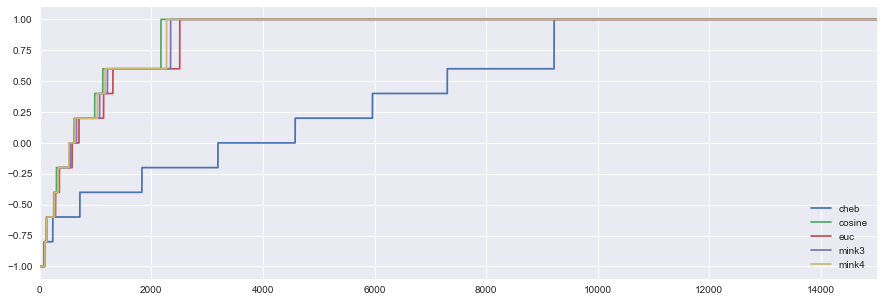

In [217]:
metric_df = pd.DataFrame(metric_margins)
metric_df.plot(figsize = (15, 5))

In [233]:
pd.DataFrame({
    'accuracy' : metric_df.apply(lambda margins: 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))
})

,accuracy
cheb,0.694800
cosine,0.958867
euc,0.953067
mink3,0.956067
mink4,0.957667


# Проклятие размерности и метрические алгоритмы
------

1. Рассмотрим единичный куб и куб с ребром длиной $ e, (e \leq 1) $ в пространстве размерности <b>D</b>. Каким должен быть $e$, чтобы малый куб занимал 1% от объема единичного куба? Рассмотрите случай, когда <b>D</b> равно 2, 10, 100.

2. Рассмотрим сферу радиуса r в пространстве размерности <b>D</b>. Какая часть объема находится между радиусоми r = 1 и $\hat r = 1-\varepsilon$.

<img src="img/Dmiension_Density.png" height="450" width="450">

** Выводы: **
- Качество метрического классификатора полностью определяется метрикой или пространством в котором находятся наши объекты. Неудачный выбор метрики или пространства приведет к низкому качеству классификации.
- Чем больше размерность пространства, тем больше требуется данных для качественной классификации
- Сложность метрических алгоритмов зависит сильно от разметности пространства признаков 

<h1 align="center"> Визуализация </h1>

# Визуализация и генерация данных 
 * See "Data Visualisation and Generation.ipynb"

In [87]:
# нарисуем данные
def plot_model_data(blue_data, red_data):
    pylab.figure(figsize=(7, 7))
    pylab.scatter(blue_data[:,0], blue_data[:,1], color="blue", alpha=0.3)
    pylab.scatter(red_data[:,0], red_data[:,1], color="red", alpha=0.3)
    pylab.show()

In [85]:
# генерация выборки из нормального распределения
def generate_gaussian(point_count, mu, transform_matrix):
    """V = transform_matrix
    function: X = mu + V.T x X
    output: Normal(mu, V.T x V)
    """
    points = np.random.randn(point_count, 2)
    points = mu + np.dot(transform_matrix.T, points.T).T
    return points

In [90]:
def generate_dataset(blue_data, red_data):
    """
    color_data:N x 2
    output: X (2N x 2), Y (2N)
    """
    X = np.r_[blue_data, red_data]
    Y = np.r_[np.zeros(blue_data.shape[0]), np.ones(red_data.shape[0])]
    return X, Y

# Границы классов для kNN 

In [5]:
# сгенерируем случайные классы
classification_problem = datasets.make_classification(n_samples=100, n_features =2, n_informative = 2, 
                                                      n_classes = 3, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=3)

In [6]:
colors = ListedColormap(['red', 'blue', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow'])

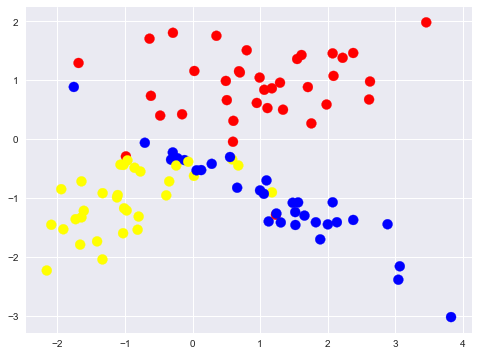

In [8]:
pylab.figure(figsize=(8,6))
pylab.scatter(list(x[0] for x in classification_problem[0]), list(x[1] for x in classification_problem[0]), 
              c=classification_problem[1], cmap=colors, s=100)

In [10]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_problem[0], 
                                                                                     classification_problem[1], 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

### Модель KNeighborsClassifier

In [11]:
clf = KNeighborsClassifier()
clf.fit(train_data, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [13]:
predictions = clf.predict(test_data)
accuracy_score(test_labels, predictions)

0.90000000000000002

In [14]:
predictions

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2,
       0, 0, 0, 1, 1, 2, 0])

### Разделяющая поверхность

In [15]:
def get_grid(data, step=.05, border=.5,):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [23]:
def plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels, 
                          colors = colors, light_colors = light_colors):
    #fit model
    estimator.fit(train_data, train_labels)
    
    #set figure size
    plt.figure(figsize = (16, 6))
    
    #plot decision surface on the train data 
    plt.subplot(1,2,1)
    xx, yy = get_grid(train_data)
    mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, cmap = colors)
    plt.title('Train data, accuracy={:.2f}'.format(accuracy_score(train_labels, estimator.predict(train_data))))
    
    #plot decision surface on the test data
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, s = 100, cmap = colors)
    plt.title('Test data, accuracy={:.2f}'.format(accuracy_score(test_labels, estimator.predict(test_data))))

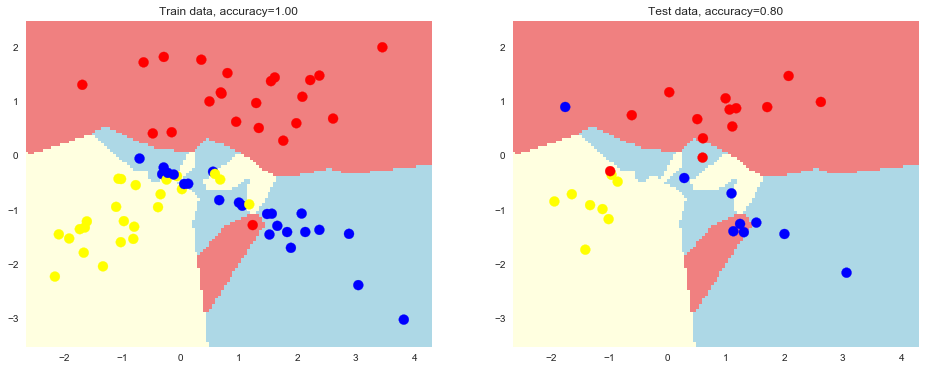

In [24]:
estimator = KNeighborsClassifier(n_neighbors=1)

plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

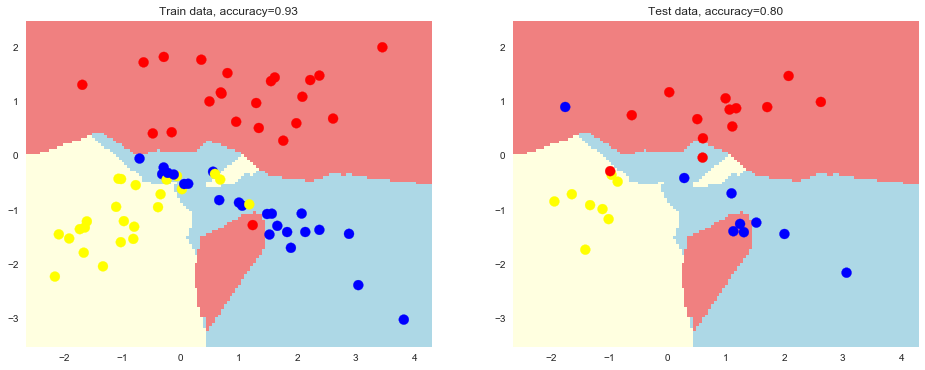

In [25]:
estimator = KNeighborsClassifier(n_neighbors=2)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

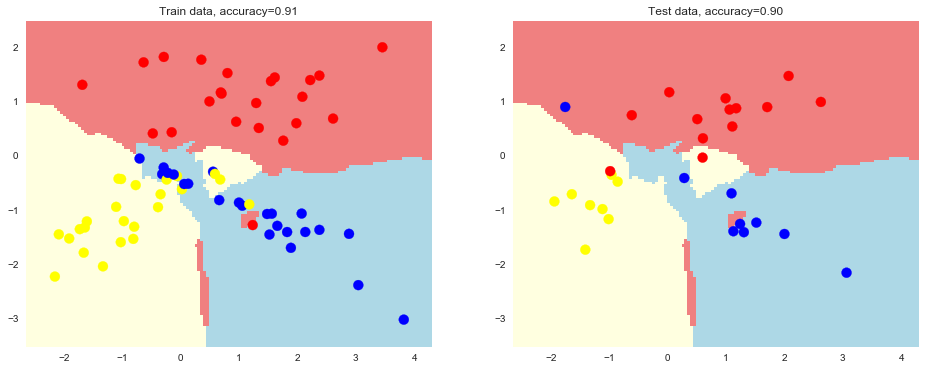

In [26]:
estimator = KNeighborsClassifier(n_neighbors=3)

plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

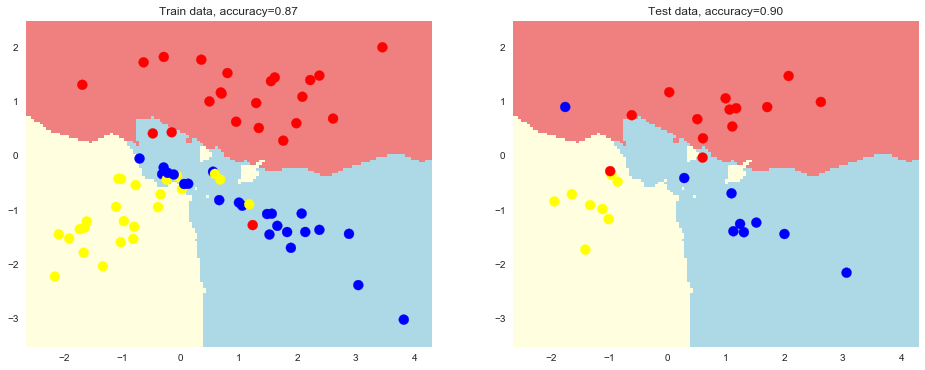

In [27]:
estimator = KNeighborsClassifier(n_neighbors=5)

plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

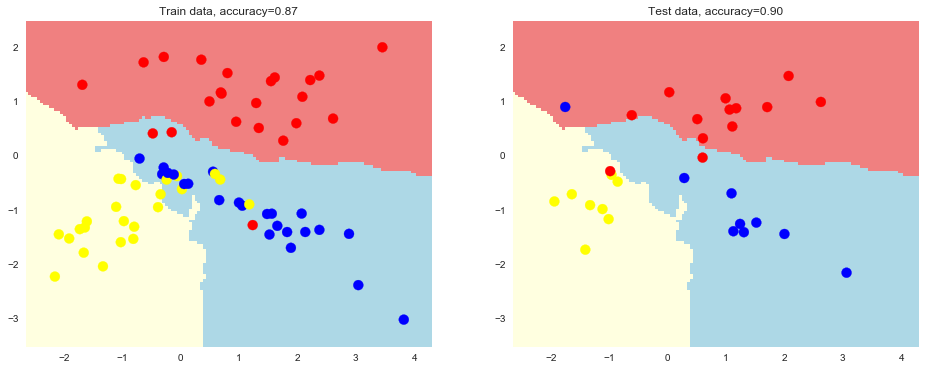

In [29]:
estimator = KNeighborsClassifier(n_neighbors=10)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

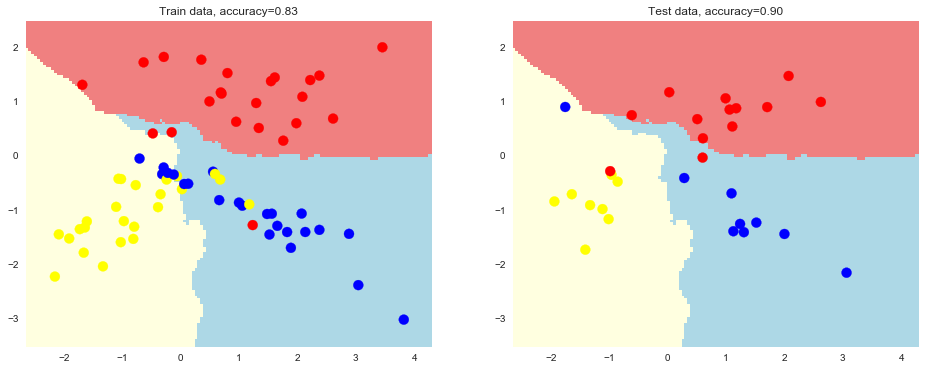

In [30]:
estimator = KNeighborsClassifier(n_neighbors=20)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

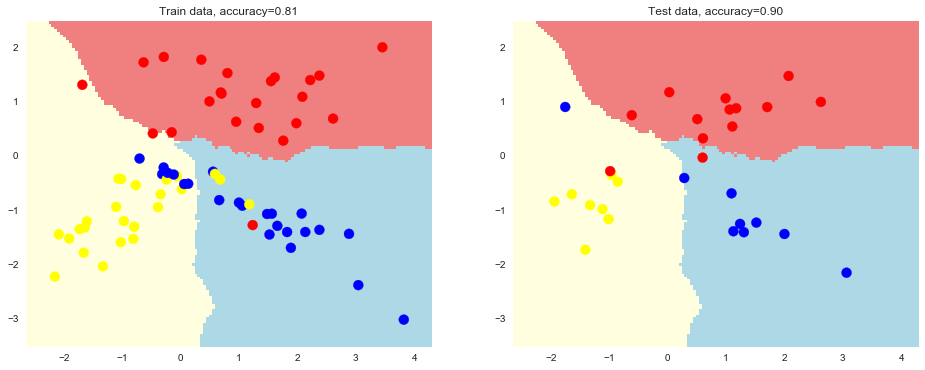

In [31]:
estimator = KNeighborsClassifier(n_neighbors=30)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

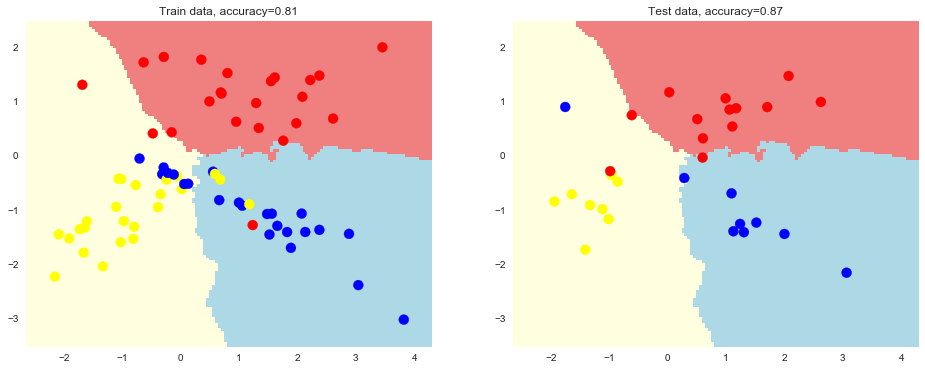

In [32]:
estimator = KNeighborsClassifier(n_neighbors=40)
plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

# kNN для гауссовских распределений

Обучим метод k ближайших соседей на примере двух нормальных распределений

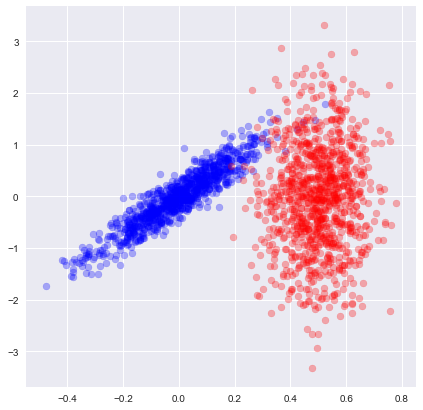

In [88]:
# Данные
blue_data = generate_gaussian(1000, (0, 0), np.array([[0.1, 0.2], [0.1, 0.5]]))
red_data = generate_gaussian(1000, (0.5, 0), np.array([[0.1, 0], [0, 1.0]]))
plot_model_data(blue_data, red_data)

In [91]:
train_X, train_Y = generate_dataset(blue_data, red_data)

In [92]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(train_X, train_Y)
print (clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


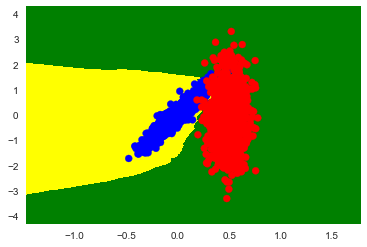

In [122]:
xx, yy = get_grid(train_X)
predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap= ListedColormap(['yellow','green']))
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, cmap = ListedColormap(['blue','red']))

Изменим параметры визуализации

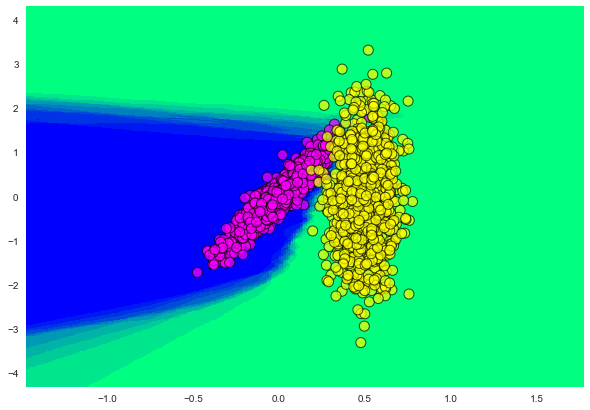

In [124]:
# Например, измените размер точек, обведите границы разменных точек, задайте прозрачность
plt.figure(figsize=(10, 7))
plt.pcolormesh(xx, yy, predicted, cmap='winter')
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y,linewidths=1, edgecolors='black', s=100, alpha=0.7, cmap='spring')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


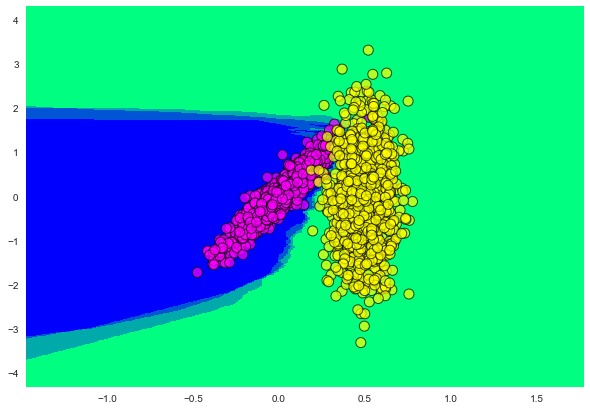

In [134]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(train_X, train_Y)
print (clf)

xx, yy = get_grid(train_X)
predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.pcolormesh(xx, yy, predicted, cmap='winter',linewidths=1)
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, linewidths=1, edgecolors='black', s=100, alpha=0.7, cmap='spring')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')


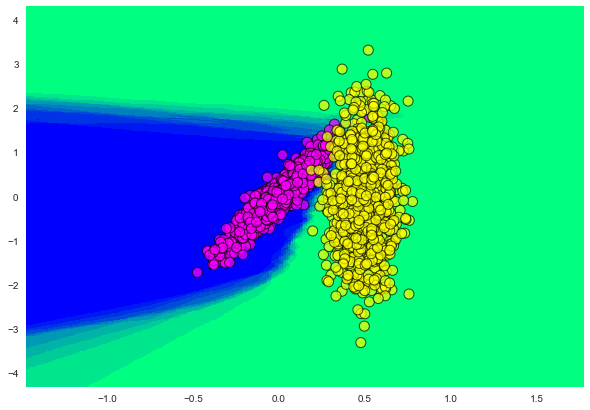

In [136]:
clf =KNeighborsClassifier(n_neighbors=10)
clf.fit(train_X, train_Y)
print (clf)

xx, yy = get_grid(train_X)
predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.figure(figsize=(10, 7))
plt.pcolormesh(xx, yy, predicted, cmap='winter')
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, linewidths=1, edgecolors='black', s=100, alpha=0.7, cmap='spring')

<h1 align="center"> Кросс-валидация и переобучение </h1>

# Переобучение

** Вопрос: ** 
 * Что такое переобучение?



  * $X$ - set of objects
  * $Y$ - set of labels
  * $y:X\rightarrow Y$ - target function


** Goal of humanity **

To find $a: X \rightarrow Y$ - algorithm or decision function approximating $y$ on $Y$

 * <span style='color:red'> Predictive model </span> - parametric family of functions:
$$A=\{g(X,\theta~|~\theta\in\Theta)\},$$

where 

$$g: X\times \Theta \rightarrow Y - \text{expert-defined function},$$

$$\Theta - \text{a set of allowable values of } \theta$$

** Goal of Machine learning (researcher) **

To find the best parametr $\theta$

* An <span style='color:red'> Learning algorithm </span> is a mapping
$$\mu: \{ X\times Y \}^\ell \rightarrow A $$
    
where $$X=\{x_i,y_i\}_{i=1}^{\ell} \text{ and   } a\in A$$

** Loss-function **

$\mathcal{L}(a,x)$ - value of error of algorithm $a \in A$ on object $x\in X$.

   * For Classification: $\mathcal{L}(a, x) = [a(x) \not= y(x)]$ - an indicator

   * For regression:
       - $L(a, x) = \bigl|a(x) − y(x)\bigr|$
       - $L(a, x) = \left(a(x) − y(x)\right)^2$

    * Other examples: <a href="https://github.com/ml-mipt/ml-mipt-part1/blob/master/2016/seminars/03_metrics/clf_reg_metrics.ipynb"> metrics overview </a>

** Эмпирический риск ** 

$$Q(a,X^\ell) = \frac{1}{\ell}\sum_{i=1}^{\ell}\mathcal{L}(a,x_i).$$

### Кривая эмпирического риска на обучащей и конрольное выборке
<img src='img/CV.jpg', Width=700pt>

<span style='color: blue, font-size=12pt'> Learing Sample = Train Set = Обучающая выборка </span>  VS
<span style='color: red, font-size=12pt'> Validation Sample = Validation Set = Контрольная выборка </span>

<span style='color: green, font-size=12pt'> Переобучение - это явление (эффект), связанное с тем, что с ростом сложности семейства алгоритмов будет ухудшаться (с некоторого момента), точность на контрольной выборке.</span>

** Вопросы **
* Как избежать переобучения? (как его обнаружить)
* Как именно разбивать выборку?

# Cross-Validation в sklearn

документация: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

## Разовое разбиение данных на обучение и тест (hold-out) с помощью train_test_split
<img src = 'img/TrainValidate.png'>

** Split dataset to train\validate (hold-out CV) ** 
  * split $X=\{x_i,y_i\}^\ell_{i=1} = X^m\cup X^k$ on 2 parts ($k+m = l$)
  * train $a = \mu(X^m).$
  * calculate quality measure $Q=Q(a,X^k)$

In [33]:
iris = datasets.load_iris()

In [35]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(iris.data, iris.target, 
                                                                                     test_size = 0.3)

In [36]:
#убедимся, что тестовая выборка действительно составляет 0.3 от всех данных
float(len(test_labels))/len(iris.data)

0.3

In [38]:
print ('Размер обучающей выборки: {} объектов \nРазмер тестовой выборки: {} объектов'.format(len(train_data),
                                                                                            len(test_data)))

Размер обучающей выборки: 105 объектов 
Размер тестовой выборки: 45 объектов


In [46]:
print ('Обучающая выборка:\n', train_data[:5],'\n')
print ('Тестовая выборка:\n', test_data[:5])

Обучающая выборка:
 [[ 7.2  3.2  6.   1.8]
 [ 5.5  3.5  1.3  0.2]
 [ 7.7  2.8  6.7  2. ]
 [ 5.   3.6  1.4  0.2]
 [ 5.   2.3  3.3  1. ]] 

Тестовая выборка:
 [[ 7.3  2.9  6.3  1.8]
 [ 5.4  3.9  1.3  0.4]
 [ 5.6  2.7  4.2  1.3]
 [ 4.6  3.1  1.5  0.2]
 [ 4.9  3.   1.4  0.2]]


In [47]:
print ('Метки классов на обучающей выборке:\n', train_labels, '\n')
print ('Метки классов на тестовой выборке:\n', test_labels)

Метки классов на обучающей выборке:
 [2 0 2 0 1 1 0 1 1 0 1 2 1 2 0 0 0 2 2 2 2 1 1 1 2 0 2 2 0 1 0 1 2 1 0 0 0
 0 1 1 1 0 0 2 0 2 0 2 2 2 1 2 0 2 2 0 2 0 0 0 1 1 2 0 1 0 2 2 0 2 2 2 2 2
 0 1 0 1 2 0 1 2 0 1 0 1 1 2 2 2 1 2 0 1 0 1 1 0 1 0 1 2 1 0 2] 

Метки классов на тестовой выборке:
 [2 0 1 0 0 2 1 2 0 0 0 2 1 1 2 0 1 1 1 1 1 2 1 0 1 2 1 2 0 1 2 1 0 2 1 1 1
 0 0 1 2 2 0 2 0]


** Вопрос: ** 
* Когда стоит пользоваться таким подходом при обучении алгоритмов?

## Стратегии проведения кросс-валидации

** Cross-validation **
   * repeat spitting for $N$ times 
   * calculate average empirical risk: 
$$CV(\mu,X^\ell)=\frac{1}{N}\sum_{n=1}^N Q(a_n,X^k_n)$$

   * types of CV
      - complete CV
      - k-fold CV
      - txq-fold CV

## KFold
<img src='img/k-fold.png'>

In [59]:
X=list(range(10))
kf = model_selection.KFold(n_splits=2)

for train_indices, test_indices in kf.split(X):
    print (train_indices, test_indices)

[5 6 7 8 9] [0 1 2 3 4]
[0 1 2 3 4] [5 6 7 8 9]


In [66]:
#многократный запуск приводит к различным разбиениям
kf = model_selection.KFold(n_splits=2,  shuffle=True)

for train_indices, test_indices in kf.split(X):
    print (train_indices, test_indices)

[1 2 6 7 9] [0 3 4 5 8]
[0 3 4 5 8] [1 2 6 7 9]


In [75]:
#многократный запуск приводит к одному и  тому же разбиению, результат запуска детерминированный
kf = model_selection.KFold(n_splits=2,  shuffle=True, random_state=1)

for train_indices, test_indices in kf.split(X):
    print (train_indices, test_indices)

[1 3 5 7 8] [0 2 4 6 9]
[0 2 4 6 9] [1 3 5 7 8]


#### StratifiedKFold

In [79]:
target = np.array([0] * 5 + [1] * 5)
print(target)
for train_indices, test_indices in model_selection.StratifiedKFold(n_splits = 2, shuffle = True, random_state = 0).split(X, target):
    print( train_indices, test_indices)

[0 0 0 0 0 1 1 1 1 1]
[3 4 8 9] [0 1 2 5 6 7]
[0 1 2 5 6 7] [3 4 8 9]


In [83]:
target = np.array([0, 1] * 5)
print(target)
for train_indices, test_indices in model_selection.StratifiedKFold(n_splits = 2, shuffle = True).split(X, target):
    print( train_indices, test_indices)

[0 1 0 1 0 1 0 1 0 1]
[0 1 3 8] [2 4 5 6 7 9]
[2 4 5 6 7 9] [0 1 3 8]


#### ShuffleSplit

In [95]:
for train_indices, test_indices in model_selection.ShuffleSplit(n_splits = 3, test_size=0.3).split(X):
    print( train_indices, test_indices)

[3 5 7 9 2 1 8] [6 4 0]
[2 6 3 9 7 1 8] [5 0 4]
[5 3 7 4 2 0 6] [1 9 8]


#### StratifiedShuffleSplit

In [100]:
target = np.array([0] * 5 + [1] * 5)
print (target)
for train_indices, test_indices in model_selection.StratifiedShuffleSplit(n_splits = 6, test_size=0.3).split(X, target):
    print (train_indices, test_indices)

[0 0 0 0 0 1 1 1 1 1]
[4 8 7 3 0 2 6] [5 1 9]
[1 0 6 5 8 3 7] [2 9 4]
[1 0 5 2 4 8 6] [9 3 7]
[8 6 9 5 0 2 4] [1 7 3]
[2 0 8 9 1 7 5] [3 6 4]
[4 5 0 2 3 8 6] [9 1 7]


#### Leave-One-Out

In [90]:
for train_indices, test_index in model_selection.LeaveOneOut().split(X):
    print (train_indices, test_index)

[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


Больше стратегий проведения кросс-валидации доступно здесь: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

# Разбиение выборки на train, validate и test
<img src='img/TrainTestValidate.png'>
** Вопрос ** зачем нужен ещё один samle (test-sample)?

In [104]:
L = 50
d = 1000

gen_train = pd.DataFrame.from_records([
        [ SystemRandom().randint(0,1)]+ [normalvariate(0, 1) for j in range(d)] 
        for i in range(L)
    ], columns = ['Label']+ ['F'+str(j)  for j in range(d)])

In [105]:
gen_train.head() # label - random Binary variable, columns -random variable from N(0,1)

,Label,F0,F1,F2,F3,F4,F5,F6,F7,F8,...,F990,F991,F992,F993,F994,F995,F996,F997,F998,F999
0,0,-0.245913,-1.129194,0.191895,0.479420,0.834467,-0.433836,-0.055969,0.692791,0.411230,...,0.153065,-0.268064,-0.730023,-0.303620,-1.129728,-1.000133,-0.207584,2.420073,1.048748,-1.890898
1,0,-0.445334,0.883236,1.130966,1.008536,-0.279630,-1.845188,-1.672233,-1.113983,0.732196,...,-0.065951,-0.111840,0.172099,2.213798,-0.660858,-1.885391,-2.426051,-0.419665,-0.135781,-0.351531
2,0,0.182807,-0.137515,-1.753202,1.653476,2.268703,1.112443,1.948756,0.761913,-0.467564,...,0.160907,-0.635797,2.113452,-0.497673,-0.865174,1.128868,-1.090470,0.065504,1.668668,1.489235
3,1,0.602200,-0.175509,1.205923,0.345629,0.721812,0.689043,-0.212439,-0.102403,1.870236,...,1.118558,0.456778,1.146704,-0.087567,-1.786138,-0.049468,0.496707,0.009250,1.929425,0.058422
4,0,0.267378,-0.209632,-0.194208,0.896388,-0.964526,0.038103,-1.354679,-0.871001,1.322254,...,-0.406174,-0.775646,-0.804455,0.022547,2.159003,-0.117022,0.307877,-1.166447,-0.312433,0.071441


In [106]:
gen_train.groupby(['Label'])['Label'].count()

Label
0    24
1    26
Name: Label, dtype: int64

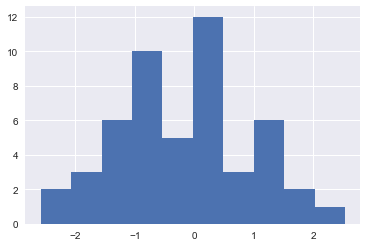

In [107]:
gen_train['F13'].hist()

In [121]:
def qFold_accuracy(x,y, estimator, cv_strategy):
    score = 0
    for train_indices, test_indices in cv_strategy.split(x):
        estimator.fit(x[train_indices], y[train_indices])
        score += estimator.score(x[test_indices], y[test_indices])
    return score/cv_strategy.get_n_splits()

## q-Fold для выбора лучшего признака

In [128]:
# Проводим эксперимент по нестройке классификатора, опирающегося на 1 признак

max_score = 0
f=0 
cv_k = 10

kf = model_selection.KFold(cv_k) 
for j in range(1,d+1):       # номер признака
    scrrr  = qFold_accuracy(np.asarray(gen_train[[gen_train.columns[j]]]),np.asarray(gen_train[['Label']]).ravel(),
                            KNeighborsClassifier(n_neighbors=3), kf)
#    print i,"-th feature = ",scrrr
    if(scrrr > max_score):
        max_score = scrrr
        f = j-1

In [215]:
# Точность при CV
print('Score on Validation Set (CV1) %.1f%%' % (max_score*100))
print('Best feature №:',f)

Score on Validation Set (CV1) 78.0%
Best feature №: 387


## Оценка точности на независимом сете

In [130]:
# estimation set
gen_test = pd.DataFrame.from_records([
        [ SystemRandom().randint(0,1)]+ [normalvariate(0, 1) for j in range(1)] 
        for i in range(100)
    ], columns = ['Label']+ ['F'+str(j)  for j in range(1)])

In [156]:
# True score on Test Set
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(np.asarray(gen_train[['F'+str(f)]]), np.asarray(gen_train[['Label']]))

print('Score on Validation Set (CV1) %.1f%%' % (100*accuracy_score(clf.predict(np.asarray(gen_test[['F0']])), np.asarray(gen_test[['Label']]))))

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score on Validation Set (CV1) 54.0%


<h1 align="center"> Summary </h1>

# Conslusion
* kNN - простой метод, но 
    * сложный алгоритмически
    * требует большого объёма данных
    * непонятно как выбирать метрику
* Переобучение тесно связано со сложностью настраиваемого семейства алгоритмов
* Самый распространённый способ избежать переобучения - разбить выборку на обучение и контроль
    * Кросс-валидация позволяет на ненабольшом объёме данных подбирать параметры модели
    * Скорр, достигнутый на кросс-валидации, НЕ описывает точность алгоритма

# Обратная связь
  * оцените <a href="https://goo.gl/forms/kYZuyAQLuwo8szce2"> семинар </a>
  * оцените <a href="https://goo.gl/forms/zeZiu1fSgrpPGp6T2"> лекцию </a>